In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import argparse
import datetime
import numpy as np
import math

# The above could be sent to an independent module
import backtrader as bt
import backtrader.feeds as btfeeds
import backtrader.indicators as btind

In [2]:
class Log(bt.MultiLogic):
    flogic = np.log

In [17]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=10,
        stake=10,
        qty1=0,
        qty2=0,
        printout=True,
        upper=2.1,
        lower=-2.1,
        up_medium=0.5,
        low_medium=-0.5,
        status=0,
        portfolio_value=10000,
    )

    def log(self, txt, dt=None):        
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        # To control operation entries
        self.orderid = None
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper
        self.lower_limit = self.p.lower
        self.up_medium = self.p.up_medium
        self.low_medium = self.p.low_medium
        self.status = self.p.status
        self.portfolio_value = self.p.portfolio_value
        
        self.data0_log = Log(self.data0)
        
        # Signals performed with PD.OLS :
        self.transform = btind.OLS_TransformationN(Log(self.data0.close), Log(self.data1.close),
                                                   period=self.p.period)
        self.zscore = self.transform.zscore

        # Checking signals built with StatsModel.API :
        # self.ols_transfo = btind.OLS_Transformation(self.data0, self.data1,
        #                                             period=self.p.period,
        #                                             plot=True)

    def next(self):

        if self.orderid:
            return  # if an order is active, no new orders are allowed

        if self.p.printout:
            print("--------------------------------------------------------------------------")
            print('Self  len:', len(self))
            print('Data0 len:', len(self.data0))
            print('Data1 len:', len(self.data1))
            print('Data0 len == Data1 len:',
                  len(self.data0) == len(self.data1))

            print('Data0 dt:', self.data0.datetime.datetime())
            print('Data1 dt:', self.data1.datetime.datetime())

        print('status is', self.status)
        print('zscore is', self.zscore[0])

        # Step 2: Check conditions for SHORT & place the order
        # Checking the condition for SHORT
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Placing the order
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % ("PEP", self.data0.close[0], x + self.qty1))
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % ("KO", self.data1.close[0], y + self.qty2))
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 1  # The current status is "short the spread"

            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Place the order
            self.log('BUY CREATE %s, price = %.2f, qty = %d' % ("PEP", self.data0.close[0], x + self.qty1))
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.log('SELL CREATE %s, price = %.2f, qty = %d' % ("KO", self.data1.close[0], y + self.qty2))
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares
            self.status = 2  # The current status is "long the spread"


            # Step 4: Check conditions for No Trade
            # If the z-score is within the two bounds, close all
       
        elif (self.zscore[0] < self.up_medium and self.zscore[0] > self.low_medium and self.status != 0):
            self.log('CLOSE LONG %s, price = %.2f' % ("PEP", self.data0.close[0]))
            self.close(self.data0)
            self.log('CLOSE LONG %s, price = %.2f' % ("KO", self.data1.close[0]))
            self.close(self.data1)
            self.status = 0
    

    def stop(self):
        print('==================================================')
        print('Starting Value - %.2f' % self.broker.startingcash)
        print('Ending   Value - %.2f' % self.broker.getvalue())
        print('==================================================')

In [18]:
def parse_args():
    parser = argparse.ArgumentParser(description='MultiData Strategy')
    
    parser.add_argument('--data0', '-d0',
                        default='C://Users//emara//Desktop//Stocks//a.us.txt',
                        help='1st data into the system')

    parser.add_argument('--data1', '-d1',
                        default='C://Users//emara//Desktop//Stocks//aa.us.txt',
                        help='2nd data into the system')

    parser.add_argument('--fromdate', '-f',
                        default='1997-01-01',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--todate', '-t',
                        default='1998-06-01',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--period', default=100, type=int,
                        help='Period to apply to the Simple Moving Average')

    parser.add_argument('--cash', default=100000, type=int,
                        help='Starting Cash')

    parser.add_argument('--runnext', action='store_true',
                        help='Use next by next instead of runonce')

    parser.add_argument('--nopreload', action='store_true',
                        help='Do not preload the data')

    parser.add_argument('--oldsync', action='store_true',
                        help='Use old data synchronization method')

    parser.add_argument('--commperc', default=0.005, type=float,
                        help='Percentage commission (0.005 is 0.5%%')

    parser.add_argument('--stake', default=10, type=int,
                        help='Stake to apply in each operation')

    parser.add_argument('--plot', '-p', default=True, action='store_true',
                        help='Plot the read data')

    parser.add_argument('--numfigs', '-n', default=1,
                        help='Plot using numfigs figures')

    return parser.parse_args()


In [19]:
args = parse_args()

# Create a cerebro
cerebro = bt.Cerebro()

# Create data feed
data0 = bt.feeds.GenericCSVData(
    dataname="C://Users//emara//Desktop//Stocks//a.us.txt",
    # Do not pass values before this date
    fromdate=datetime.datetime(1999, 11, 10),
    # Do not pass values before this date
    todate=datetime.datetime(2002, 12, 20),
    # Do not pass values after this date
    dtformat=("%Y-%m-%d"),
    datetime = 0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1,
    reverse=False)

data1 = bt.feeds.GenericCSVData(
    dataname="C://Users//emara//Desktop//Stocks//aa.us.txt",
    # Do not pass values before this date
    fromdate=datetime.datetime(1999, 11, 10),
    # Do not pass values before this date
    todate=datetime.datetime(2002, 12, 20),
    # Do not pass values after this date
    dtformat=("%Y-%m-%d"),
    datetime = 0,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest=-1,
    reverse=False)

cerebro.adddata(data0)

data1.plotinfo.plotmaster = data0
data1.plotinfo.sameaxis = True

# Add the 2nd data to cerebro
cerebro.adddata(data1)

# Add the strategy
cerebro.addstrategy(PairTradingStrategy,
                    period=args.period,
                    stake=args.stake)

# Add Sharpe Ratio
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')

# Add the commission - only stocks like a for each operation
cerebro.broker.setcash(args.cash)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcommission(commission=args.commperc)

# And run it
strat = cerebro.run(runonce=not args.runnext,
                preload=not args.nopreload,
                oldsync=args.oldsync)

--------------------------------------------------------------------------
Self  len: 114
Data0 len: 109
Data1 len: 114
Data0 len == Data1 len: False
Data0 dt: 2000-04-25 23:59:59.999989
Data1 dt: 2000-04-25 23:59:59.999989
status is 0
zscore is 0.19894376028565006
--------------------------------------------------------------------------
Self  len: 115
Data0 len: 110
Data1 len: 115
Data0 len == Data1 len: False
Data0 dt: 2000-04-26 23:59:59.999989
Data1 dt: 2000-04-26 23:59:59.999989
status is 0
zscore is -0.29859390012839165
--------------------------------------------------------------------------
Self  len: 116
Data0 len: 111
Data1 len: 116
Data0 len == Data1 len: False
Data0 dt: 2000-04-27 23:59:59.999989
Data1 dt: 2000-04-27 23:59:59.999989
status is 0
zscore is -0.31294374746273274
--------------------------------------------------------------------------
Self  len: 117
Data0 len: 112
Data1 len: 117
Data0 len == Data1 len: False
Data0 dt: 2000-04-28 23:59:59.999989
Data1 dt: 200

Data0 dt: 2000-09-21 23:59:59.999989
Data1 dt: 2000-09-21 23:59:59.999989
status is 0
zscore is 0.6870464809223296
--------------------------------------------------------------------------
Self  len: 219
Data0 len: 213
Data1 len: 219
Data0 len == Data1 len: False
Data0 dt: 2000-09-22 23:59:59.999989
Data1 dt: 2000-09-22 23:59:59.999989
status is 0
zscore is 0.6187479172192498
--------------------------------------------------------------------------
Self  len: 220
Data0 len: 214
Data1 len: 220
Data0 len == Data1 len: False
Data0 dt: 2000-09-25 23:59:59.999989
Data1 dt: 2000-09-25 23:59:59.999989
status is 0
zscore is 0.5779791779446471
--------------------------------------------------------------------------
Self  len: 221
Data0 len: 215
Data1 len: 221
Data0 len == Data1 len: False
Data0 dt: 2000-09-26 23:59:59.999989
Data1 dt: 2000-09-26 23:59:59.999989
status is 0
zscore is 0.5906132745854952
--------------------------------------------------------------------------
Self  len: 222


Data0 len: 366
Data1 len: 371
Data0 len == Data1 len: False
Data0 dt: 2001-05-03 23:59:59.999989
Data1 dt: 2001-05-03 23:59:59.999989
status is 0
zscore is -0.2824893432876368
--------------------------------------------------------------------------
Self  len: 373
Data0 len: 367
Data1 len: 372
Data0 len == Data1 len: False
Data0 dt: 2001-05-04 23:59:59.999989
Data1 dt: 2001-05-04 23:59:59.999989
status is 0
zscore is -0.25780138526249635
--------------------------------------------------------------------------
Self  len: 374
Data0 len: 368
Data1 len: 373
Data0 len == Data1 len: False
Data0 dt: 2001-05-07 23:59:59.999989
Data1 dt: 2001-05-07 23:59:59.999989
status is 0
zscore is -0.16565410084472384
--------------------------------------------------------------------------
Self  len: 375
Data0 len: 369
Data1 len: 374
Data0 len == Data1 len: False
Data0 dt: 2001-05-08 23:59:59.999989
Data1 dt: 2001-05-08 23:59:59.999989
status is 0
zscore is -0.3871404667329617
------------------------

Data1 dt: 2001-12-07 23:59:59.999989
status is 1
zscore is 1.1916845383792247
--------------------------------------------------------------------------
Self  len: 521
Data0 len: 515
Data1 len: 520
Data0 len == Data1 len: False
Data0 dt: 2001-12-10 23:59:59.999989
Data1 dt: 2001-12-10 23:59:59.999989
status is 1
zscore is -1.2080284247282687
--------------------------------------------------------------------------
Self  len: 522
Data0 len: 516
Data1 len: 521
Data0 len == Data1 len: False
Data0 dt: 2001-12-11 23:59:59.999989
Data1 dt: 2001-12-11 23:59:59.999989
status is 1
zscore is -0.6554171438727571
--------------------------------------------------------------------------
Self  len: 523
Data0 len: 517
Data1 len: 522
Data0 len == Data1 len: False
Data0 dt: 2001-12-12 23:59:59.999989
Data1 dt: 2001-12-12 23:59:59.999989
status is 1
zscore is 0.6616222730380038
--------------------------------------------------------------------------
Self  len: 524
Data0 len: 518
Data1 len: 523
Data0

Data1 dt: 2002-07-08 23:59:59.999989
status is 0
zscore is -0.32910525479406827
--------------------------------------------------------------------------
Self  len: 665
Data0 len: 659
Data1 len: 664
Data0 len == Data1 len: False
Data0 dt: 2002-07-09 23:59:59.999989
Data1 dt: 2002-07-09 23:59:59.999989
status is 0
zscore is -0.465232024918866
--------------------------------------------------------------------------
Self  len: 666
Data0 len: 660
Data1 len: 665
Data0 len == Data1 len: False
Data0 dt: 2002-07-10 23:59:59.999989
Data1 dt: 2002-07-10 23:59:59.999989
status is 0
zscore is -0.5638626089209194
--------------------------------------------------------------------------
Self  len: 667
Data0 len: 661
Data1 len: 666
Data0 len == Data1 len: False
Data0 dt: 2002-07-11 23:59:59.999989
Data1 dt: 2002-07-11 23:59:59.999989
status is 0
zscore is -0.49637998243791775
--------------------------------------------------------------------------
Self  len: 668
Data0 len: 662
Data1 len: 667
Da

In [20]:
print('Sharpe Ratio (default):', strat[0].analyzers.mysharpe.get_analysis())

Sharpe Ratio (default): OrderedDict([('sharperatio', -1.1294767433922845)])


C:\Users\emara\Anaconda3\envs\traders_nlp\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
C:\Users\emara\Anaconda3\envs\traders_nlp\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


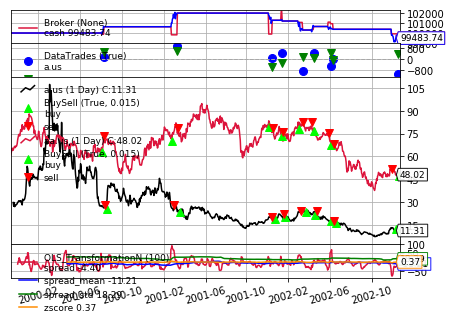

In [21]:
# Plot if requested
if args.plot:
    cerebro.plot(numfigs=args.numfigs, volume=False, zdown=False)

In [52]:
print(bt.analyzers)

<module 'backtrader.analyzers' from 'C:\\Users\\emara\\Anaconda3\\envs\\traders_nlp\\lib\\site-packages\\backtrader\\analyzers\\__init__.py'>
